# Model Setup

In [ ]:
from dataclasses import dataclass
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Optional, Tuple
from torch.utils.data import DataLoader, Dataset
from transformers import GPT2Tokenizer
from datasets import load_dataset, concatenate_datasets
import os
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

In [ ]:


save_dir_drive = 'ENTER DIRECTORY'
checkpoint_dir_drive = 'ENTER DIRECTORY'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
@dataclass
class MiniGPTConfig:
    """Configuration class for MiniGPT model"""

    # Model architecture
    vocab_size: int = 50257
    hidden_size: int = 256
    num_hidden_layers: int = 6
    num_attention_heads: int = 8
    num_key_value_heads: Optional[int] = None
    intermediate_size: Optional[int] = None
    max_position_embeddings: int = 512

    # Attention configuration
    attention_dropout: float = 0.1
    attention_bias: bool = False

    # MLP configuration
    hidden_act: str = "silu"

    # Normalization
    norm_type: str = "rmsnorm"
    rms_norm_eps: float = 1e-6
    layer_norm_eps: float = 1e-5

    # Regularization
    hidden_dropout: float = 0.1
    embedding_dropout: float = 0.1

    # Activation clamping (to suppress super activations)
    clamp_activations: bool = False
    clamp_value: float = 100.0
    clamp_intermediate: bool = True
    clamp_output: bool = True

    # Other
    pad_token_id: int = 50256
    use_cache: bool = True

    def __post_init__(self):
        # Set defaults
        if self.num_key_value_heads is None:
            self.num_key_value_heads = self.num_attention_heads
        if self.intermediate_size is None:
            self.intermediate_size = 4 * self.hidden_size

        # Validation
        assert self.hidden_size % self.num_attention_heads == 0, \
            "hidden_size must be divisible by num_attention_heads"
        assert self.num_attention_heads % self.num_key_value_heads == 0, \
            "num_attention_heads must be divisible by num_key_value_heads"

In [ ]:
class RMSNorm(nn.Module):
    """Root Mean Square Layer Normalization"""
    def __init__(self, hidden_size: int, eps: float = 1e-6):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(hidden_size))
        self.variance_epsilon = eps

    def forward(self, hidden_states: torch.Tensor) -> torch.Tensor:
        input_dtype = hidden_states.dtype
        hidden_states = hidden_states.to(torch.float32)
        variance = hidden_states.pow(2).mean(-1, keepdim=True)
        hidden_states = hidden_states * torch.rsqrt(variance + self.variance_epsilon)
        return self.weight * hidden_states.to(input_dtype)


class MiniGPTMLP(nn.Module):
    """MLP with configurable activation function"""
    def __init__(self, config: MiniGPTConfig):
        super().__init__()
        self.config = config
        self.hidden_size = config.hidden_size
        self.intermediate_size = config.intermediate_size

        if config.hidden_act == "swiglu":
            # SwiGLU requires gate projection
            self.gate_proj = nn.Linear(self.hidden_size, self.intermediate_size, bias=False)
            self.up_proj = nn.Linear(self.hidden_size, self.intermediate_size, bias=False)
            self.down_proj = nn.Linear(self.intermediate_size, self.hidden_size, bias=False)
            self.act_fn = nn.SiLU()
        else:
            self.fc1 = nn.Linear(self.hidden_size, self.intermediate_size)
            self.fc2 = nn.Linear(self.intermediate_size, self.hidden_size)
            if config.hidden_act == "gelu":
                self.act_fn = nn.GELU()
            elif config.hidden_act == "relu":
                self.act_fn = nn.ReLU()
            elif config.hidden_act == "silu":
                self.act_fn = nn.SiLU()
            else:
                raise ValueError(f"Unsupported activation: {config.hidden_act}")

        self.dropout = nn.Dropout(config.hidden_dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.config.hidden_act == "swiglu":
            # SwiGLU
            intermediate = self.act_fn(self.gate_proj(x)) * self.up_proj(x)

            # Clamp intermediate activations (prevents super activation formation)
            if self.config.clamp_activations and self.config.clamp_intermediate:
                intermediate = torch.clamp(
                    intermediate,
                    -self.config.clamp_value,
                    self.config.clamp_value
                )

            down_proj = self.down_proj(intermediate)

            # Clamp output activations (double safety)
            if self.config.clamp_activations and self.config.clamp_output:
                down_proj = torch.clamp(
                    down_proj,
                    -self.config.clamp_value,
                    self.config.clamp_value
                )

            return self.dropout(down_proj)
        else:
            x = self.fc1(x)
            x = self.act_fn(x)

            if self.config.clamp_activations and self.config.clamp_intermediate:
                x = torch.clamp(x, -self.config.clamp_value, self.config.clamp_value)

            x = self.fc2(x)

            if self.config.clamp_activations and self.config.clamp_output:
                x = torch.clamp(x, -self.config.clamp_value, self.config.clamp_value)

            return self.dropout(x)

def repeat_kv(hidden_states: torch.Tensor, n_rep: int) -> torch.Tensor:
    """Repeat key/value heads for Grouped Query Attention"""
    batch, num_key_value_heads, slen, head_dim = hidden_states.shape
    if n_rep == 1:
        return hidden_states
    hidden_states = hidden_states[:, :, None, :, :].expand(batch, num_key_value_heads, n_rep, slen, head_dim)
    return hidden_states.reshape(batch, num_key_value_heads * n_rep, slen, head_dim)


class MiniGPTAttention(nn.Module):
    """Multi-head/Grouped-query attention"""
    def __init__(self, config: MiniGPTConfig):
        super().__init__()
        self.config = config
        self.hidden_size = config.hidden_size
        self.num_attention_heads = config.num_attention_heads
        self.num_key_value_heads = config.num_key_value_heads
        self.head_dim = self.hidden_size // self.num_attention_heads
        self.num_key_value_groups = self.num_attention_heads // self.num_key_value_heads
        self.scaling = self.head_dim ** -0.5

        self.q_proj = nn.Linear(self.hidden_size, self.num_attention_heads * self.head_dim, bias=config.attention_bias)
        self.k_proj = nn.Linear(self.hidden_size, self.num_key_value_heads * self.head_dim, bias=config.attention_bias)
        self.v_proj = nn.Linear(self.hidden_size, self.num_key_value_heads * self.head_dim, bias=config.attention_bias)
        self.o_proj = nn.Linear(self.num_attention_heads * self.head_dim, self.hidden_size, bias=config.attention_bias)

        self.attn_dropout = nn.Dropout(config.attention_dropout)
        self.resid_dropout = nn.Dropout(config.hidden_dropout)

    def forward(
        self,
        hidden_states: torch.Tensor,
        attention_mask: Optional[torch.Tensor] = None,
        use_cache: bool = False,
        past_key_value: Optional[Tuple[torch.Tensor]] = None,
    ) -> Tuple[torch.Tensor, Optional[Tuple[torch.Tensor]]]:
        batch_size, seq_len, _ = hidden_states.shape

        # Project queries, keys, values
        query_states = self.q_proj(hidden_states)
        key_states = self.k_proj(hidden_states)
        value_states = self.v_proj(hidden_states)

        # Reshape to separate heads
        query_states = query_states.view(batch_size, seq_len, self.num_attention_heads, self.head_dim).transpose(1, 2)
        key_states = key_states.view(batch_size, seq_len, self.num_key_value_heads, self.head_dim).transpose(1, 2)
        value_states = value_states.view(batch_size, seq_len, self.num_key_value_heads, self.head_dim).transpose(1, 2)

        # Handle cached keys/values for generation
        if past_key_value is not None:
            key_states = torch.cat([past_key_value[0], key_states], dim=2)
            value_states = torch.cat([past_key_value[1], value_states], dim=2)

        past_key_value = (key_states, value_states) if use_cache else None

        # Repeat k/v heads if using GQA/MQA
        key_states = repeat_kv(key_states, self.num_key_value_groups)
        value_states = repeat_kv(value_states, self.num_key_value_groups)

        # Compute attention scores
        attn_weights = torch.matmul(query_states, key_states.transpose(2, 3)) * self.scaling

        if attention_mask is not None:
            attn_weights = attn_weights + attention_mask

        attn_weights = F.softmax(attn_weights, dim=-1, dtype=torch.float32).to(query_states.dtype)
        attn_weights = self.attn_dropout(attn_weights)

        # Compute attention output
        attn_output = torch.matmul(attn_weights, value_states)
        attn_output = attn_output.transpose(1, 2).contiguous()
        attn_output = attn_output.reshape(batch_size, seq_len, self.hidden_size)

        attn_output = self.o_proj(attn_output)
        attn_output = self.resid_dropout(attn_output)

        return attn_output, past_key_value


class MiniGPTBlock(nn.Module):
    """Transformer decoder block"""
    def __init__(self, config: MiniGPTConfig):
        super().__init__()
        self.hidden_size = config.hidden_size

        # Select normalization type
        if config.norm_type == "rmsnorm":
            self.ln_1 = RMSNorm(config.hidden_size, eps=config.rms_norm_eps)
            self.ln_2 = RMSNorm(config.hidden_size, eps=config.rms_norm_eps)
        elif config.norm_type == "layernorm":
            self.ln_1 = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
            self.ln_2 = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        else:
            raise ValueError(f"Unsupported norm_type: {config.norm_type}")

        self.attn = MiniGPTAttention(config)
        self.mlp = MiniGPTMLP(config)

    def forward(
        self,
        hidden_states: torch.Tensor,
        attention_mask: Optional[torch.Tensor] = None,
        use_cache: bool = False,
        past_key_value: Optional[Tuple[torch.Tensor]] = None,
    ) -> Tuple[torch.Tensor, Optional[Tuple[torch.Tensor]]]:
        # Self-attention with residual
        residual = hidden_states
        hidden_states = self.ln_1(hidden_states)
        hidden_states, present_key_value = self.attn(
            hidden_states,
            attention_mask=attention_mask,
            use_cache=use_cache,
            past_key_value=past_key_value,
        )
        hidden_states = residual + hidden_states

        # MLP with residual
        residual = hidden_states
        hidden_states = self.ln_2(hidden_states)
        hidden_states = self.mlp(hidden_states)
        hidden_states = residual + hidden_states

        return hidden_states, present_key_value


class MiniGPT(nn.Module):
    """Mini-GPT Model"""
    def __init__(self, config: MiniGPTConfig):
        super().__init__()
        self.config = config

        self.wte = nn.Embedding(config.vocab_size, config.hidden_size)
        self.wpe = nn.Embedding(config.max_position_embeddings, config.hidden_size)
        self.drop = nn.Dropout(config.embedding_dropout)

        self.h = nn.ModuleList([MiniGPTBlock(config) for _ in range(config.num_hidden_layers)])

        if config.norm_type == "rmsnorm":
            self.ln_f = RMSNorm(config.hidden_size, eps=config.rms_norm_eps)
        else:
            self.ln_f = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)

        self.lm_head = nn.Linear(config.hidden_size, config.vocab_size, bias=False)

        # Weight tying
        self.wte.weight = self.lm_head.weight

        # Initialize weights
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(
        self,
        input_ids: torch.Tensor,
        attention_mask: Optional[torch.Tensor] = None,
        past_key_values: Optional[Tuple[Tuple[torch.Tensor]]] = None,
        use_cache: bool = False,
        labels: Optional[torch.Tensor] = None,
    ) -> Tuple[torch.Tensor, Optional[torch.Tensor], Optional[Tuple]]:
        batch_size, seq_len = input_ids.shape

        # Get past length for position ids
        past_length = 0
        if past_key_values is not None:
            past_length = past_key_values[0][0].shape[2]

        # Position ids
        position_ids = torch.arange(past_length, seq_len + past_length, dtype=torch.long, device=input_ids.device)
        position_ids = position_ids.unsqueeze(0)

        # Embeddings
        hidden_states = self.wte(input_ids) + self.wpe(position_ids)
        hidden_states = self.drop(hidden_states)

        # Prepare causal mask
        if attention_mask is None:
            attention_mask = torch.ones((batch_size, seq_len + past_length), dtype=torch.bool, device=input_ids.device)

        # Create causal mask
        causal_mask = torch.triu(
            torch.ones(seq_len, seq_len + past_length, dtype=torch.bool, device=input_ids.device),
            diagonal=1
        )
        causal_mask = causal_mask.masked_fill(causal_mask, float('-inf'))
        causal_mask = causal_mask.unsqueeze(0).unsqueeze(0)

        # Transformer blocks
        present_key_values = () if use_cache else None
        for i, block in enumerate(self.h):
            past_key_value = past_key_values[i] if past_key_values is not None else None
            hidden_states, present_key_value = block(
                hidden_states,
                attention_mask=causal_mask,
                use_cache=use_cache,
                past_key_value=past_key_value,
            )
            if use_cache:
                present_key_values = present_key_values + (present_key_value,)

        hidden_states = self.ln_f(hidden_states)
        logits = self.lm_head(hidden_states)

        # Compute loss if labels provided
        loss = None
        if labels is not None:
            shift_logits = logits[..., :-1, :].contiguous()
            shift_labels = labels[..., 1:].contiguous()
            loss = F.cross_entropy(
                shift_logits.view(-1, self.config.vocab_size),
                shift_labels.view(-1),
                ignore_index=-100
            )

        return logits, loss, present_key_values

    def generate(
        self,
        input_ids: torch.Tensor,
        max_new_tokens: int = 50,
        temperature: float = 1.0,
        top_k: Optional[int] = None,
    ) -> torch.Tensor:
        """Simple autoregressive generation"""
        self.eval()
        with torch.no_grad():
            for _ in range(max_new_tokens):
                # Crop to max position embeddings
                idx_cond = input_ids if input_ids.size(1) <= self.config.max_position_embeddings else input_ids[:, -self.config.max_position_embeddings:]

                logits, _, _ = self(idx_cond)
                logits = logits[:, -1, :] / temperature

                if top_k is not None:
                    v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                    logits[logits < v[:, [-1]]] = -float('Inf')

                probs = F.softmax(logits, dim=-1)
                idx_next = torch.multinomial(probs, num_samples=1)
                input_ids = torch.cat((input_ids, idx_next), dim=1)

        return input_ids

# Dataset Setup

In [ ]:
class WikiTextDataset(Dataset):
    """WikiText dataset wrapper"""
    def __init__(self, data, tokenizer, max_length=512):
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.examples = []

        # Tokenize all texts
        print("Tokenizing dataset...")
        for item in tqdm(data):
            text = item['text']
            if len(text.strip()) > 0:
                tokens = tokenizer.encode(text, truncation=True, max_length=max_length)
                if len(tokens) > 1:
                    self.examples.append(tokens)

        print(f"Created {len(self.examples)} examples")

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        tokens = self.examples[idx]
        # Pad if necessary
        if len(tokens) < self.max_length:
            tokens = tokens + [self.tokenizer.pad_token_id] * (self.max_length - len(tokens))
        return torch.tensor(tokens[:self.max_length], dtype=torch.long)


def train_epoch(model, dataloader, optimizer, device, grad_clip=1.0):
    """Train for one epoch"""
    model.train()
    total_loss = 0

    progress_bar = tqdm(dataloader, desc="Training")
    for batch_idx, batch in enumerate(progress_bar):
        input_ids = batch.to(device)

        labels = input_ids.clone()
        labels[labels == tokenizer.pad_token_id] = -100

        # Forward pass with masked labels
        logits, loss, _ = model(input_ids, labels=labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()

        # Gradient clipping
        if grad_clip > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

        optimizer.step()

        total_loss += loss.item()
        progress_bar.set_postfix({'loss': loss.item()})

    return total_loss / len(dataloader)


def evaluate(model, dataloader, device):
    """Evaluate on validation set"""
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch.to(device)

            labels = input_ids.clone()
            labels[labels == tokenizer.pad_token_id] = -100

            logits, loss, _ = model(input_ids, labels=labels)
            total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    perplexity = math.exp(avg_loss)
    return avg_loss, perplexity

# Hooks and Saving

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

class MLPMonitor:
    """Monitor and visualize MLP weights and activations during training - Paper Style"""
    def __init__(self):
        self.weight_history = defaultdict(list)  # epoch -> list of max weights per layer
        self.activation_history = defaultdict(list)  # epoch -> list of max activations per layer
        self.down_proj_input_history = defaultdict(list)  # Track down_proj inputs
        self.down_proj_output_history = defaultdict(list)  # Track down_proj outputs
        self.block_output_history = defaultdict(list)  # Track block outputs (for super activations)
        self.hooks = []
        self.current_activations = []
        self.current_down_proj_inputs = []
        self.current_down_proj_outputs = []
        self.current_block_outputs = []

    def register_hooks(self, model):
        """Register forward hooks to capture activations like in the paper"""
        self.hooks = []
        self.current_activations = []
        self.current_down_proj_inputs = []
        self.current_down_proj_outputs = []
        self.current_block_outputs = []

        for i, block in enumerate(model.h):
            if hasattr(block.mlp, 'act_fn'):
                def make_act_hook(layer_idx):
                    def hook(module, input, output):
                        max_act = output.abs().max().item()
                        if len(self.current_activations) <= layer_idx:
                            self.current_activations.append(max_act)
                        else:
                            self.current_activations[layer_idx] = max(
                                self.current_activations[layer_idx], max_act
                            )
                    return hook

                handle = block.mlp.act_fn.register_forward_hook(make_act_hook(i))
                self.hooks.append(handle)

            if hasattr(block.mlp, 'down_proj'):
                down_proj_layer = block.mlp.down_proj
            elif hasattr(block.mlp, 'fc2'):
                down_proj_layer = block.mlp.fc2
            else:
                continue

            def make_down_input_hook(layer_idx):
                def hook(module, input, output):
                    max_val = input[0].abs().max().item()
                    if len(self.current_down_proj_inputs) <= layer_idx:
                        self.current_down_proj_inputs.append(max_val)
                    else:
                        self.current_down_proj_inputs[layer_idx] = max(
                            self.current_down_proj_inputs[layer_idx], max_val
                        )
                return hook

            handle = down_proj_layer.register_forward_hook(make_down_input_hook(i))
            self.hooks.append(handle)

            def make_down_output_hook(layer_idx):
                def hook(module, input, output):
                    max_val = output.abs().max().item()
                    if len(self.current_down_proj_outputs) <= layer_idx:
                        self.current_down_proj_outputs.append(max_val)
                    else:
                        self.current_down_proj_outputs[layer_idx] = max(
                            self.current_down_proj_outputs[layer_idx], max_val
                            )
                return hook

            handle = down_proj_layer.register_forward_hook(make_down_output_hook(i))
            self.hooks.append(handle)

            def make_block_output_hook(layer_idx):
                def hook(module, input, output):
                    hidden_states = output[0] if isinstance(output, tuple) else output
                    max_val = hidden_states.abs().max().item()
                    if len(self.current_block_outputs) <= layer_idx:
                        self.current_block_outputs.append(max_val)
                    else:
                        self.current_block_outputs[layer_idx] = max(
                            self.current_block_outputs[layer_idx], max_val
                        )
                return hook

            handle = block.register_forward_hook(make_block_output_hook(i))
            self.hooks.append(handle)

    def remove_hooks(self):
        """Remove all registered hooks"""
        for hook in self.hooks:
            hook.remove()
        self.hooks = []

    def collect_weights(self, model):
        """Collect max absolute weights from each MLP layer"""
        max_weights = []

        for block in model.h:
            mlp = block.mlp
            layer_max = 0

            if hasattr(mlp, 'gate_proj'):
                layer_max = max(
                    mlp.gate_proj.weight.abs().max().item(),
                    mlp.up_proj.weight.abs().max().item(),
                    mlp.down_proj.weight.abs().max().item()
                )
            else:
                layer_max = max(
                    mlp.fc1.weight.abs().max().item(),
                    mlp.fc2.weight.abs().max().item()
                )

            max_weights.append(layer_max)

        return max_weights

    def collect_down_proj_weights(self, model):
        """Collect max absolute weights from down_proj/fc2 only (where super weights live)"""
        down_proj_max_weights = []

        for block in model.h:
            mlp = block.mlp
            if hasattr(mlp, 'down_proj'):  # SwiGLU
                down_proj_max = mlp.down_proj.weight.abs().max().item()
            elif hasattr(mlp, 'fc2'):  # Standard MLP
                down_proj_max = mlp.fc2.weight.abs().max().item()
            else:
                down_proj_max = 0.0
            down_proj_max_weights.append(down_proj_max)

        return down_proj_max_weights

    def collect_stats(self, model, verbose=True):
        """Collect and optionally print statistics"""
        stats = {
            'weights': {'max': [], 'mean': [], 'std': []},
            'activations': {'max': [], 'mean': [], 'std': []},
            'down_proj_inputs': {'max': []},
            'down_proj_outputs': {'max': []},
            'block_outputs': {'max': []}
        }

        for i, block in enumerate(model.h):
            mlp = block.mlp

            if hasattr(mlp, 'gate_proj'):  # SwiGLU
                weights = torch.cat([
                    mlp.gate_proj.weight.flatten(),
                    mlp.up_proj.weight.flatten(),
                    mlp.down_proj.weight.flatten()
                ])
            else:  # Standard MLP
                weights = torch.cat([
                    mlp.fc1.weight.flatten(),
                    mlp.fc2.weight.flatten()
                ])

            stats['weights']['max'].append(weights.abs().max().item())
            stats['weights']['mean'].append(weights.abs().mean().item())
            stats['weights']['std'].append(weights.std().item())

        # Activation statistics (already collected during forward pass)
        if self.current_activations:
            stats['activations']['max'] = self.current_activations.copy()
        if self.current_down_proj_inputs:
            stats['down_proj_inputs']['max'] = self.current_down_proj_inputs.copy()
        if self.current_down_proj_outputs:
            stats['down_proj_outputs']['max'] = self.current_down_proj_outputs.copy()
        if self.current_block_outputs:
            stats['block_outputs']['max'] = self.current_block_outputs.copy()

        if verbose:
            print("\n" + "="*60)
            print("MLP Statistics Summary")
            print("="*60)

            if model.config.clamp_activations:
              print(f"ACTIVATION CLAMPING ENABLED")
              print(f"  Clamp value: ±{model.config.clamp_value}")
              print(f"  Clamp intermediate: {model.config.clamp_intermediate}")
              print(f"  Clamp output: {model.config.clamp_output}")

            print("\nWeights:")
            print(f"  Max across layers: {max(stats['weights']['max']):.4f}")
            print(f"  Min across layers: {min(stats['weights']['max']):.4f}")
            print(f"  Mean: {np.mean(stats['weights']['mean']):.4f}")

            if stats['activations']['max']:
                print("\nMLP Activations (after act_fn):")
                print(f"  Max across layers: {max(stats['activations']['max']):.4f}")
                print(f"  Min across layers: {min(stats['activations']['max']):.4f}")
                print(f"  Mean: {np.mean(stats['activations']['max']):.4f}")

            if stats['down_proj_outputs']['max']:
                print("\ndown_proj Outputs:")
                print(f"  Max across layers: {max(stats['down_proj_outputs']['max']):.4f}")
                print(f"  Min across layers: {min(stats['down_proj_outputs']['max']):.4f}")

            if stats['block_outputs']['max']:
                print("\nBlock Outputs (after residual - Fig 4 pattern):")
                print(f"  Max across layers: {max(stats['block_outputs']['max']):.4f}")
                print(f"  Min across layers: {min(stats['block_outputs']['max']):.4f}")

            print("="*60 + "\n")

        return stats

    def record_epoch(self, epoch, model):
        """Record weights and activations for this epoch"""
        max_weights = self.collect_weights(model)
        max_activations = self.current_activations.copy() if self.current_activations else []
        down_proj_inputs = self.current_down_proj_inputs.copy() if self.current_down_proj_inputs else []
        down_proj_outputs = self.current_down_proj_outputs.copy() if self.current_down_proj_outputs else []
        block_outputs = self.current_block_outputs.copy() if self.current_block_outputs else []

        self.weight_history[epoch] = max_weights
        self.activation_history[epoch] = max_activations
        self.down_proj_input_history[epoch] = down_proj_inputs
        self.down_proj_output_history[epoch] = down_proj_outputs
        self.block_output_history[epoch] = block_outputs

        # Reset activations for next epoch
        self.current_activations = []
        self.current_down_proj_inputs = []
        self.current_down_proj_outputs = []
        self.current_block_outputs = []

    def plot(self, epoch, save_dir='plots', save_dir_drive=None):
      """Plot max weights and activations vs layer number (paper style)"""
      import os

      # Create both directories
      os.makedirs(save_dir, exist_ok=True)
      if save_dir_drive is not None:
          os.makedirs(save_dir_drive, exist_ok=True)

      num_layers = len(self.weight_history[epoch])
      layer_indices = list(range(num_layers))

      # Plot 1: Weights
      plt.figure(figsize=(10, 6))
      plt.plot(layer_indices, self.weight_history[epoch], 'bo-', linewidth=2, markersize=8)
      plt.xlabel('Layer Number', fontsize=12)
      plt.ylabel('Max Absolute Weight', fontsize=12)
      plt.title(f'Maximum MLP Weights by Layer (Epoch {epoch})', fontsize=14)
      plt.grid(True, alpha=0.3)
      plt.tight_layout()
      plt.savefig(f'{save_dir}/weights_epoch_{epoch}.png', dpi=150)
      if save_dir_drive is not None:
          plt.savefig(f'{save_dir_drive}/weights_epoch_{epoch}.png', dpi=150)
      plt.show()
      plt.close()

      # Plot 2: MLP Activations
      if self.activation_history[epoch]:
          plt.figure(figsize=(10, 6))
          plt.plot(layer_indices, self.activation_history[epoch], 'ro-', linewidth=2, markersize=8)
          plt.xlabel('Layer Number', fontsize=12)
          plt.ylabel('Max Activation', fontsize=12)
          plt.title(f'Maximum MLP Activations by Layer (Epoch {epoch})', fontsize=14)
          plt.grid(True, alpha=0.3)
          plt.tight_layout()
          plt.savefig(f'{save_dir}/activations_epoch_{epoch}.png', dpi=150)
          if save_dir_drive is not None:
              plt.savefig(f'{save_dir_drive}/activations_epoch_{epoch}.png', dpi=150)
          plt.show()
          plt.close()

      # Plot 3: down_proj Input
      if self.down_proj_input_history[epoch]:
          plt.figure(figsize=(10, 6))
          plt.plot(layer_indices, self.down_proj_input_history[epoch], 'go-', linewidth=2, markersize=8)
          plt.xlabel('Layer Number', fontsize=12)
          plt.ylabel('Max down_proj Input', fontsize=12)
          plt.title(f'Max down_proj Input by Layer (Epoch {epoch}) - Paper Fig 3 Left', fontsize=14)
          plt.grid(True, alpha=0.3)
          plt.tight_layout()
          plt.savefig(f'{save_dir}/down_proj_input_epoch_{epoch}.png', dpi=150)
          if save_dir_drive is not None:
              plt.savefig(f'{save_dir_drive}/down_proj_input_epoch_{epoch}.png', dpi=150)
          plt.show()
          plt.close()

      # Plot 4: down_proj Output
      if self.down_proj_output_history[epoch]:
          plt.figure(figsize=(10, 6))
          plt.plot(layer_indices, self.down_proj_output_history[epoch], 'mo-', linewidth=2, markersize=8)
          plt.xlabel('Layer Number', fontsize=12)
          plt.ylabel('Max down_proj Output', fontsize=12)
          plt.title(f'Max down_proj Output by Layer (Epoch {epoch}) - Paper Fig 3 Right', fontsize=14)
          plt.grid(True, alpha=0.3)
          plt.tight_layout()
          plt.savefig(f'{save_dir}/down_proj_output_epoch_{epoch}.png', dpi=150)
          if save_dir_drive is not None:
              plt.savefig(f'{save_dir_drive}/down_proj_output_epoch_{epoch}.png', dpi=150)
          plt.show()
          plt.close()

      # Plot 5: Block Output
      if self.block_output_history[epoch]:
          plt.figure(figsize=(10, 6))
          plt.plot(layer_indices, self.block_output_history[epoch], 'co-', linewidth=2, markersize=8)
          plt.axhline(y=np.mean(self.block_output_history[epoch][3:]) if len(self.block_output_history[epoch]) > 3 else 0,
                    color='r', linestyle='--', alpha=0.5, label='Mean (layers 3+)')
          plt.xlabel('Layer Number', fontsize=12)
          plt.ylabel('Max Block Output', fontsize=12)
          plt.title(f'Max Block Output by Layer (Epoch {epoch}) - Paper Fig 4 Pattern', fontsize=14)
          plt.legend()
          plt.grid(True, alpha=0.3)
          plt.tight_layout()
          plt.savefig(f'{save_dir}/block_output_epoch_{epoch}.png', dpi=150)
          if save_dir_drive is not None:
              plt.savefig(f'{save_dir_drive}/block_output_epoch_{epoch}.png', dpi=150)
          plt.show()
          plt.close()

      print(f"Plots saved to {save_dir}/")
      if save_dir_drive is not None:
          print(f"Plots also saved to {save_dir_drive}/")


def evaluate_with_monitoring(model, dataloader, device, monitor=None):
    """Evaluate on validation set with optional MLP monitoring"""
    model.eval()
    total_loss = 0

    # Reset monitor activations if provided
    if monitor:
        monitor.current_activations = []
        monitor.current_down_proj_inputs = []
        monitor.current_down_proj_outputs = []
        monitor.current_block_outputs = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch.to(device)

            labels = input_ids.clone()
            labels[labels == tokenizer.pad_token_id] = -100

            logits, loss, _ = model(input_ids, labels=labels)
            total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    perplexity = math.exp(avg_loss)
    return avg_loss, perplexity

# Train Model

Using device: cuda
Loading tokenizer...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Loading datasets...


README.md: 0.00B [00:00, ?B/s]

wikitext-2-raw-v1/test-00000-of-00001.pa(…):   0%|          | 0.00/733k [00:00<?, ?B/s]

wikitext-2-raw-v1/train-00000-of-00001.p(…):   0%|          | 0.00/6.36M [00:00<?, ?B/s]

wikitext-2-raw-v1/validation-00000-of-00(…):   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00004-2d5a1467fff108(…):   0%|          | 0.00/249M [00:00<?, ?B/s]

data/train-00001-of-00004-5852b56a2bd28f(…):   0%|          | 0.00/248M [00:00<?, ?B/s]

data/train-00002-of-00004-a26307300439e9(…):   0%|          | 0.00/246M [00:00<?, ?B/s]

data/train-00003-of-00004-d243063613e5a0(…):   0%|          | 0.00/248M [00:00<?, ?B/s]

data/validation-00000-of-00001-869c898b5(…):   0%|          | 0.00/9.99M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2119719 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/21990 [00:00<?, ? examples/s]

Tokenizing dataset...


100%|██████████| 460662/460662 [10:08<00:00, 756.56it/s]


Created 447657 examples
Tokenizing dataset...


100%|██████████| 8158/8158 [00:07<00:00, 1082.19it/s]


Created 6859 examples

Initializing model...
Model has 47,718,144 trainable parameters
Model configuration: MiniGPTConfig(vocab_size=50257, hidden_size=384, num_hidden_layers=12, num_attention_heads=6, num_key_value_heads=6, intermediate_size=1536, max_position_embeddings=256, attention_dropout=0.1, attention_bias=False, hidden_act='swiglu', norm_type='rmsnorm', rms_norm_eps=1e-06, layer_norm_eps=1e-05, hidden_dropout=0.1, embedding_dropout=0.1, clamp_activations=False, clamp_value=100.0, clamp_intermediate=True, clamp_output=True, pad_token_id=50256, use_cache=True)

Starting training...

Epoch 1/3


Training: 100%|██████████| 27979/27979 [1:58:58<00:00,  3.92it/s, loss=0.0246]


Train Loss: 0.0875


Evaluating: 100%|██████████| 429/429 [00:37<00:00, 11.37it/s]


Val Loss: 0.0544, Perplexity: 1.06

MLP Statistics Summary

Weights:
  Max across layers: 0.3322
  Min across layers: 0.2229
  Mean: 0.0342

MLP Activations (after act_fn):
  Max across layers: 20.2018
  Min across layers: 4.6970
  Mean: 8.6774

down_proj Outputs:
  Max across layers: 178.0983
  Min across layers: 12.8050

Block Outputs (after residual - Fig 4 pattern):
  Max across layers: 247.1438
  Min across layers: 179.6250
  ⚠️  POSSIBLE SUPER ACTIVATION DETECTED!
     Later layers show low variation (std=16.80)



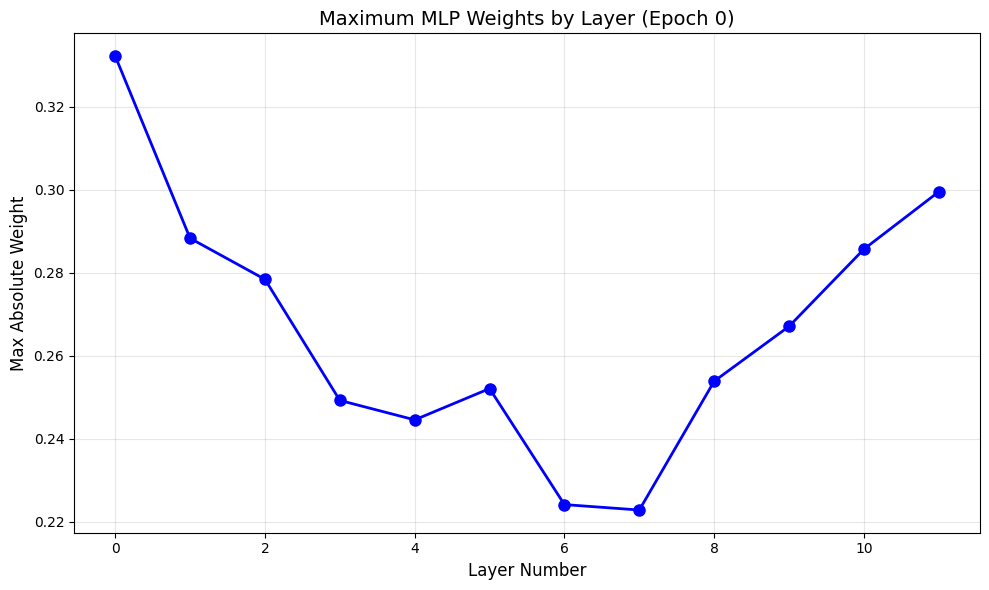

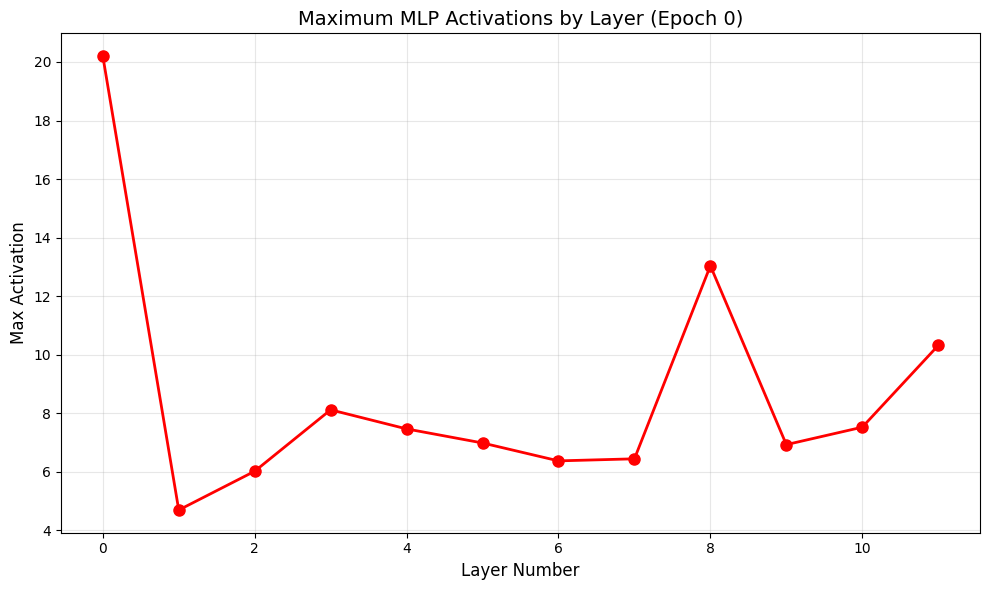

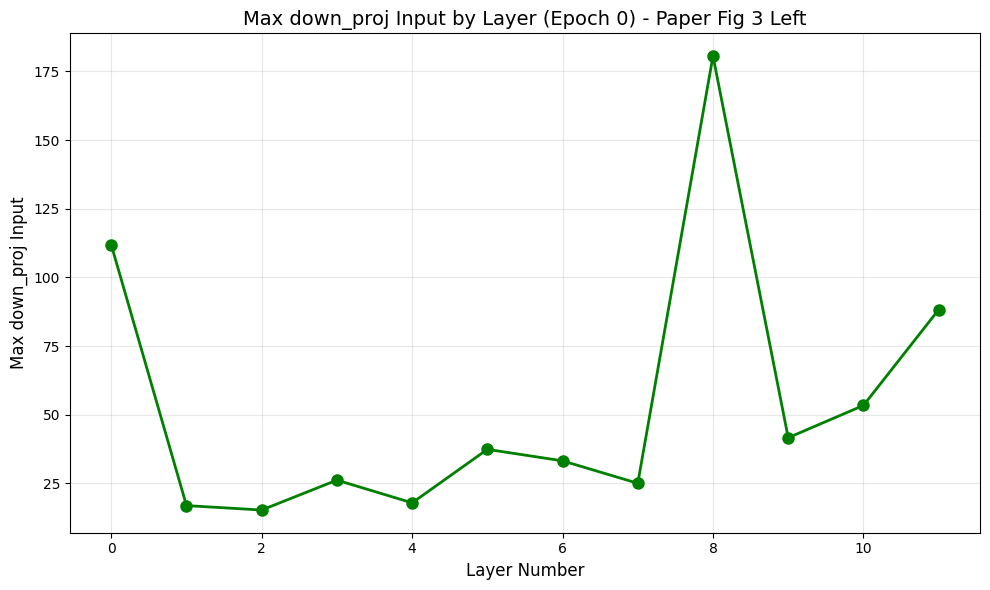

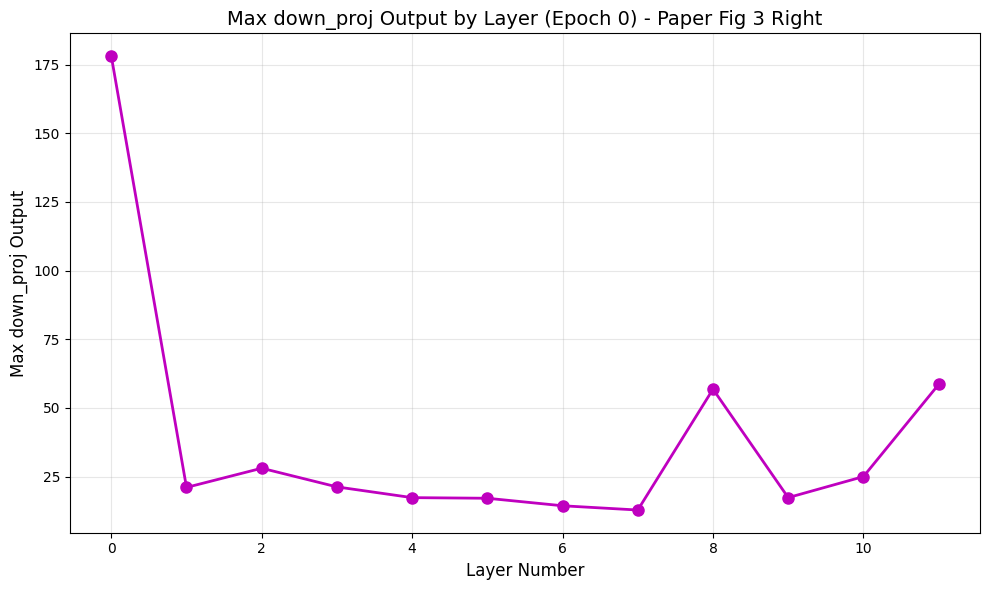

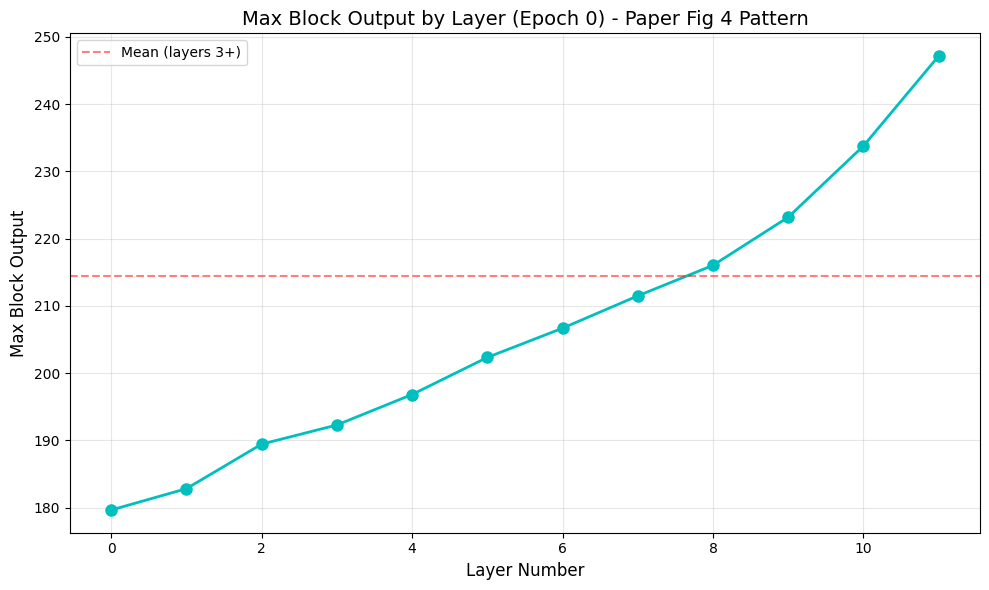

Plots saved to plots/
Plots also saved to /content/drive/MyDrive/dl_final_project/plots/

💾 Saving checkpoint...
✅ Saved to local: /content/checkpoint_epoch_0.pt
✅ Copied to Drive: /content/drive/MyDrive/dl_final_project/checkpoints/swiglu_baseline_40m_epoch_0.pt
✅ Verified Drive copy (572760861 bytes)
❌ Verification failed: Weights only load failed. This file can still be loaded, to do so you have two options, do those steps only if you trust the source of the checkpoint. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL __main__.MiniGPTConfig was not an allowed globa

Training: 100%|██████████| 27979/27979 [1:58:54<00:00,  3.92it/s, loss=7.05e-5]


Train Loss: 0.0050


Evaluating: 100%|██████████| 429/429 [00:37<00:00, 11.29it/s]


Val Loss: 0.0476, Perplexity: 1.05

MLP Statistics Summary

Weights:
  Max across layers: 0.6508
  Min across layers: 0.3740
  Mean: 0.0477

MLP Activations (after act_fn):
  Max across layers: 20.7681
  Min across layers: 5.2283
  Mean: 9.5400

down_proj Outputs:
  Max across layers: 364.8733
  Min across layers: 31.1614

Block Outputs (after residual - Fig 4 pattern):
  Max across layers: 562.9876
  Min across layers: 367.3888



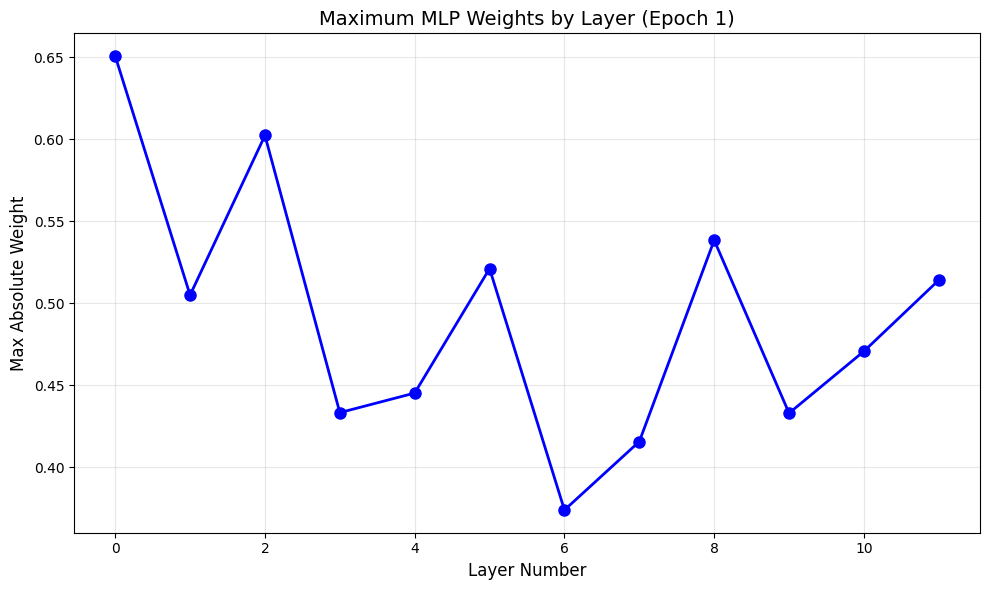

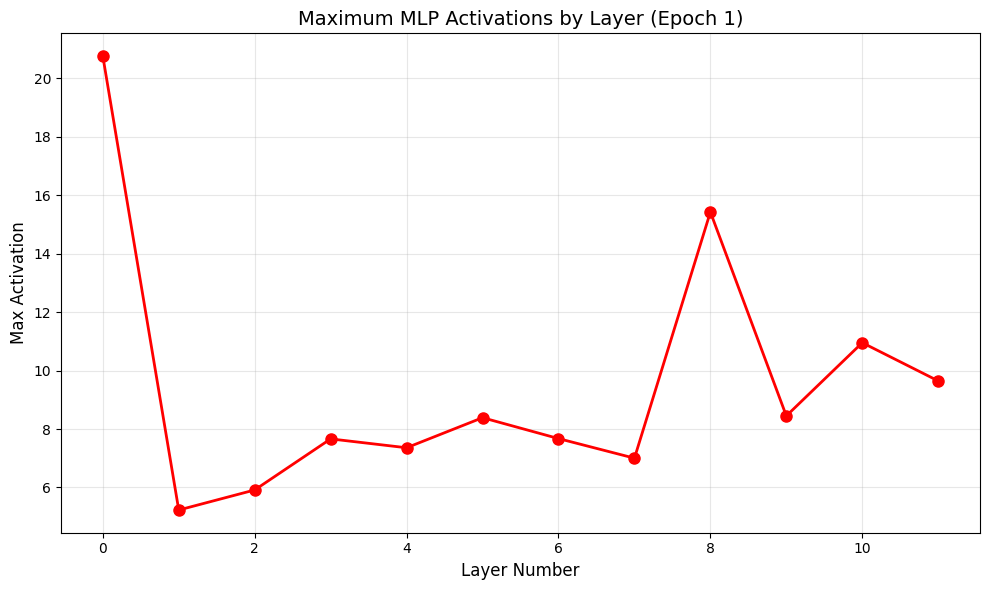

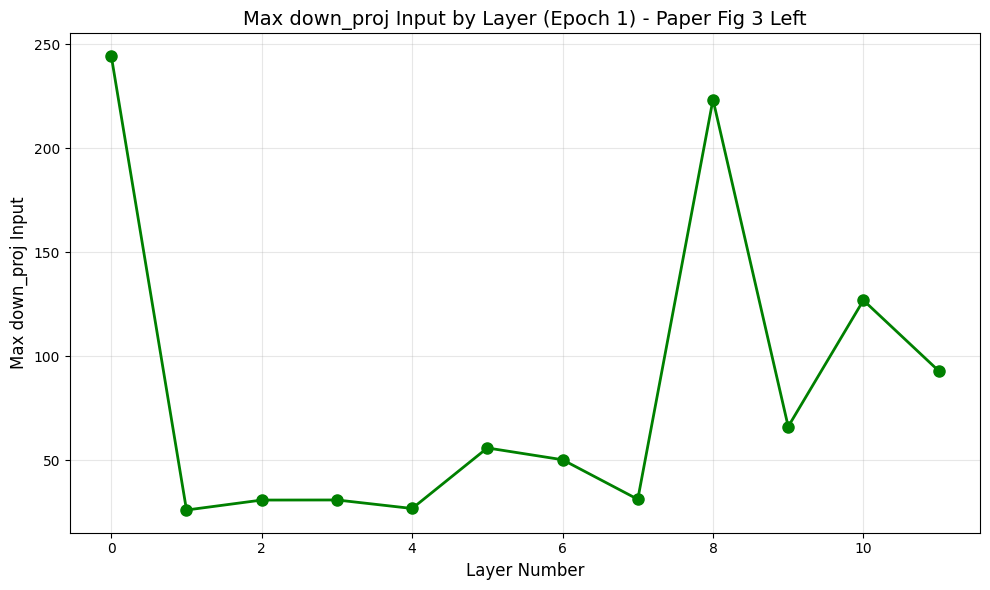

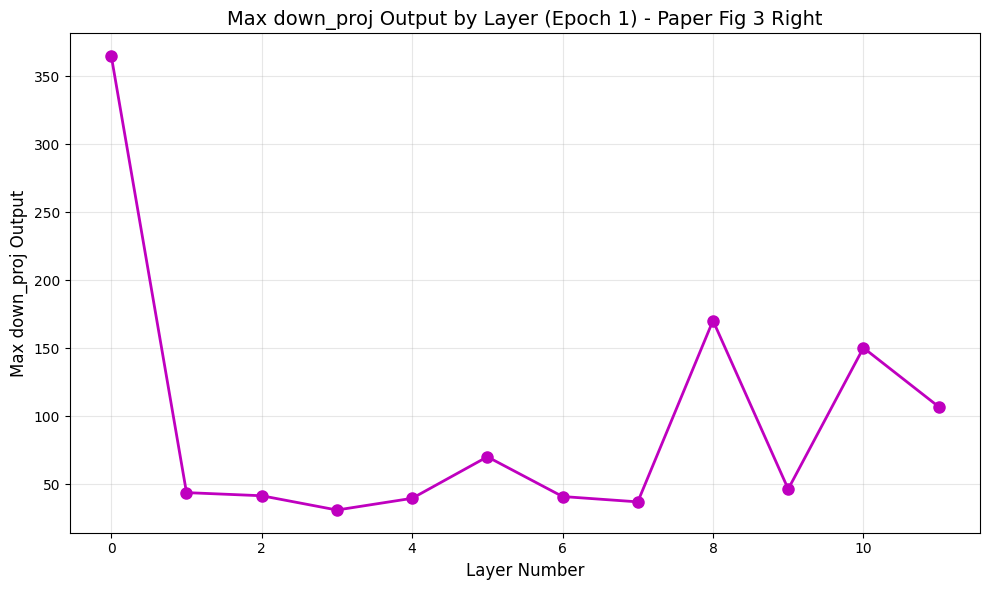

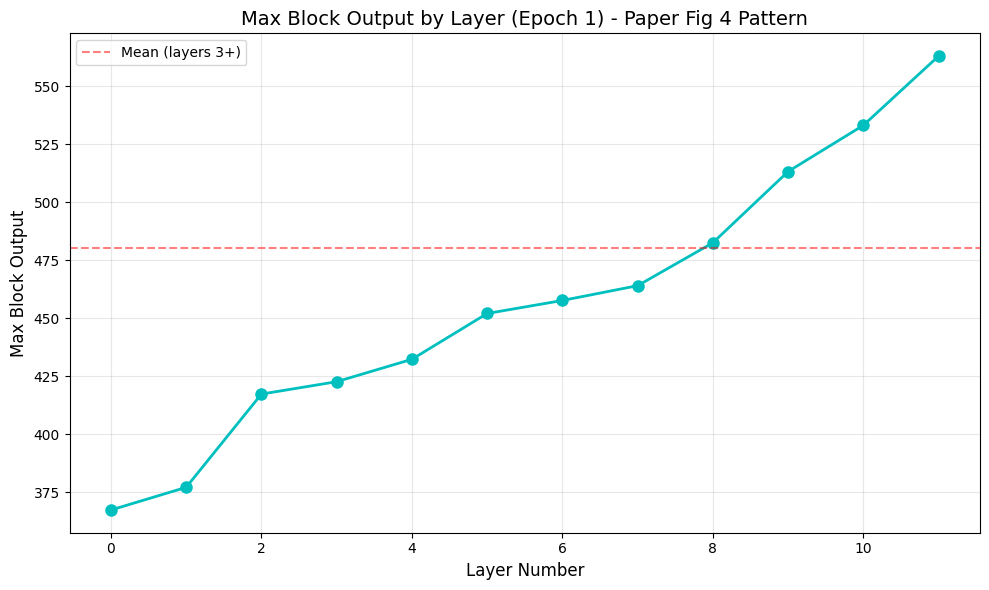

Plots saved to plots/
Plots also saved to /content/drive/MyDrive/dl_final_project/plots/

💾 Saving checkpoint...
✅ Saved to local: /content/checkpoint_epoch_1.pt
✅ Copied to Drive: /content/drive/MyDrive/dl_final_project/checkpoints/swiglu_baseline_40m_epoch_1.pt
✅ Verified Drive copy (572760861 bytes)
❌ Verification failed: Weights only load failed. This file can still be loaded, to do so you have two options, do those steps only if you trust the source of the checkpoint. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL __main__.MiniGPTConfig was not an allowed globa

Training: 100%|██████████| 27979/27979 [1:58:59<00:00,  3.92it/s, loss=0.00304]


Train Loss: 0.0048


Evaluating: 100%|██████████| 429/429 [00:37<00:00, 11.37it/s]


Val Loss: 0.0498, Perplexity: 1.05

MLP Statistics Summary

Weights:
  Max across layers: 0.8593
  Min across layers: 0.5677
  Mean: 0.0566

MLP Activations (after act_fn):
  Max across layers: 20.8778
  Min across layers: 5.3178
  Mean: 10.0727

down_proj Outputs:
  Max across layers: 344.4544
  Min across layers: 50.7326

Block Outputs (after residual - Fig 4 pattern):
  Max across layers: 1142.4161
  Min across layers: 345.3507



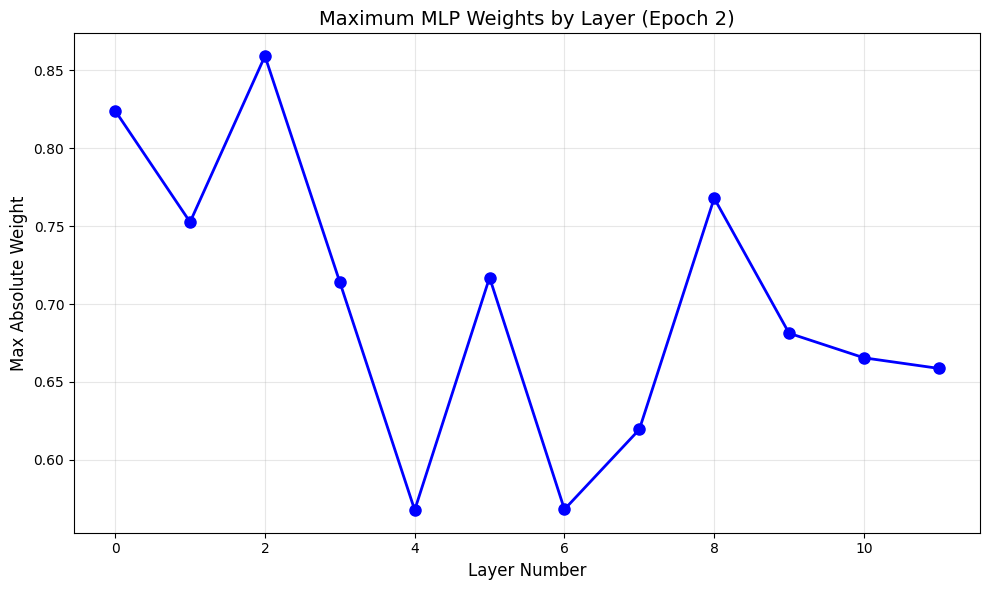

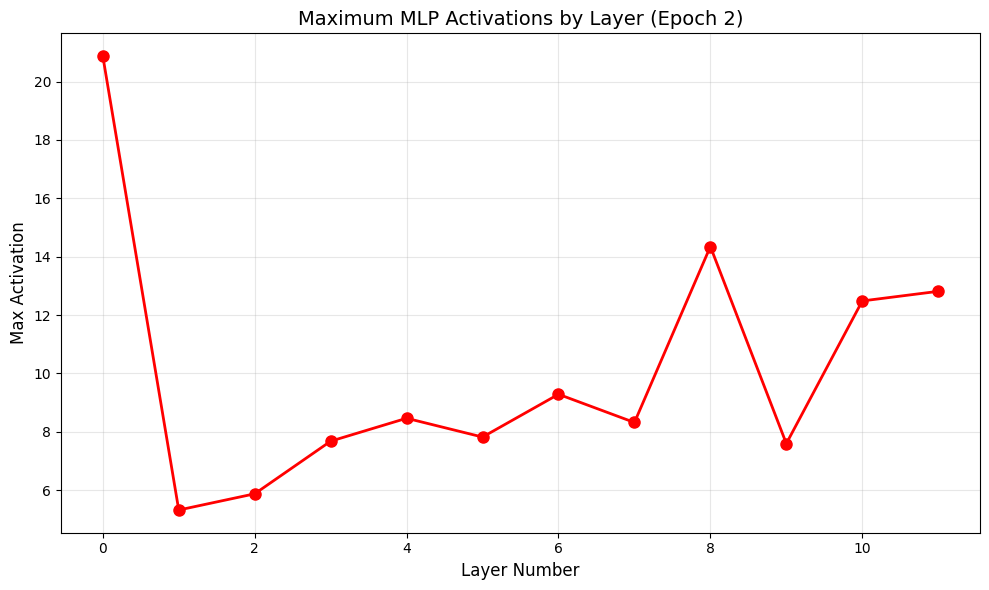

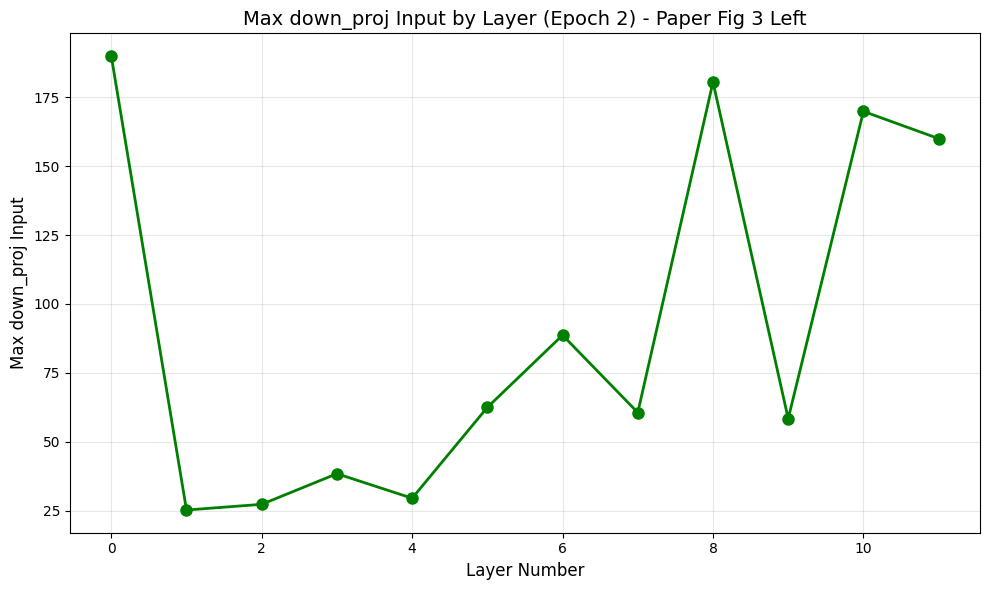

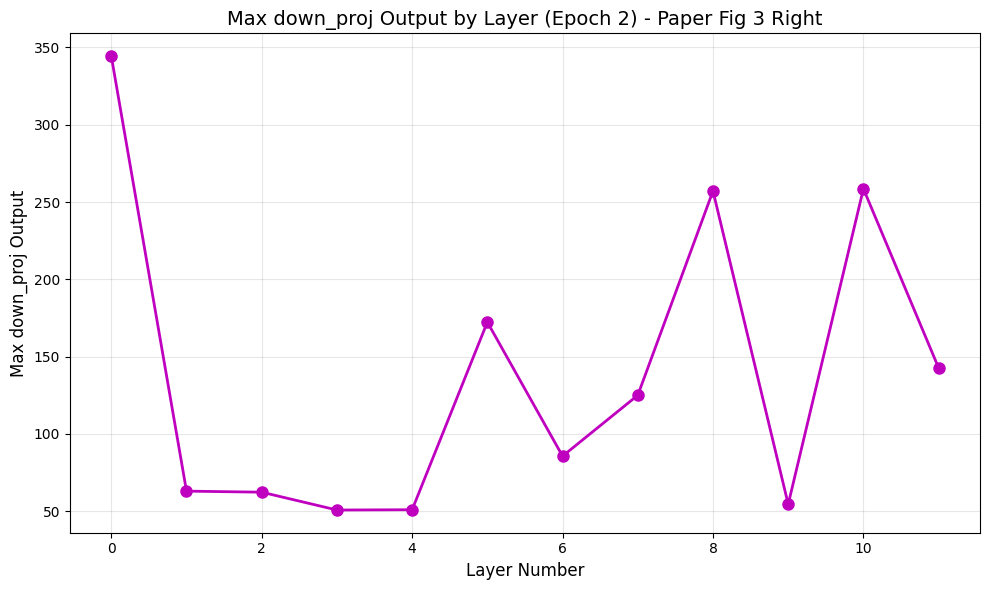

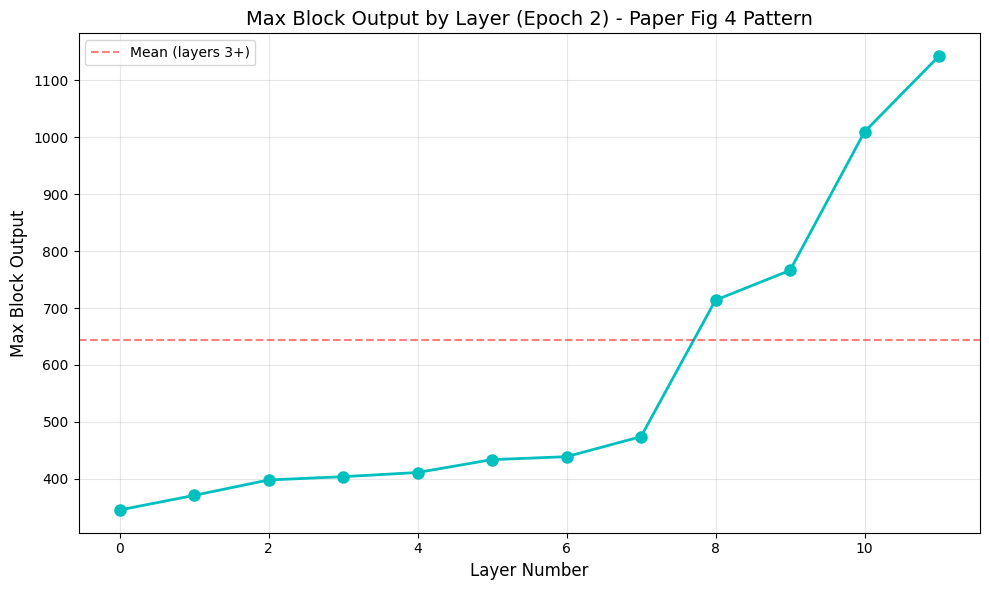

Plots saved to plots/
Plots also saved to /content/drive/MyDrive/dl_final_project/plots/

💾 Saving checkpoint...
✅ Saved to local: /content/checkpoint_epoch_2.pt
✅ Copied to Drive: /content/drive/MyDrive/dl_final_project/checkpoints/swiglu_baseline_40m_epoch_2.pt
✅ Verified Drive copy (572760861 bytes)
❌ Verification failed: Weights only load failed. This file can still be loaded, to do so you have two options, do those steps only if you trust the source of the checkpoint. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL __main__.MiniGPTConfig was not an allowed globa

In [ ]:
import gc
import time

# Clear any existing models/tensors
torch.cuda.empty_cache()
gc.collect()

# Training configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Model configuration
config = MiniGPTConfig(
    vocab_size=50257,
    hidden_size=384,
    num_hidden_layers=12,
    num_attention_heads=6,
    num_key_value_heads=6,
    max_position_embeddings=256,
    hidden_act="swiglu",
    norm_type="rmsnorm",
    attention_dropout=0.1,
    hidden_dropout=0.1,
    embedding_dropout=0.1,
)

batch_size = 16
num_epochs = 3
learning_rate = 3e-4
grad_clip = 1.0


tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token

from datasets import load_dataset, concatenate_datasets

wikitext = load_dataset('wikitext', 'wikitext-2-raw-v1')

tinystories_train = load_dataset('roneneldan/TinyStories', split='train[:20%]')
tinystories_val = load_dataset('roneneldan/TinyStories', split='validation[:20%]')

combined_train = concatenate_datasets([
    wikitext['train'],
    tinystories_train
])

combined_val = concatenate_datasets([
    wikitext['validation'],
    tinystories_val
])

train_dataset = WikiTextDataset(combined_train, tokenizer, max_length=256)
val_dataset = WikiTextDataset(combined_val, tokenizer, max_length=256)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


model = MiniGPT(config)
model = model.to(device)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model has {num_params:,} trainable parameters")
print(f"Model configuration: {config}")

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

monitor = MLPMonitor()
monitor.register_hooks(model)
plot_every_n_epochs = 1


best_val_loss = float('inf')
experiment_name = "swiglu_baseline_40m"

for epoch in range(num_epochs):
    print(f"\n{'='*50}")
    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"{'='*50}")

    train_loss = train_epoch(model, train_dataloader, optimizer, device, grad_clip)
    print(f"Train Loss: {train_loss:.4f}")

    val_loss, val_perplexity = evaluate_with_monitoring(model, val_dataloader, device, monitor)
    print(f"Val Loss: {val_loss:.4f}, Perplexity: {val_perplexity:.2f}")

    if (epoch + 1) % plot_every_n_epochs == 0:
        stats = monitor.collect_stats(model, verbose=True)
        monitor.record_epoch(epoch, model)
        monitor.plot(epoch, save_dir='plots', save_dir_drive=save_dir_drive)

    # Generate sample
    print("\nGenerating sample text...")
    model.eval()
    prompt = "The history of"
    input_ids = torch.tensor([tokenizer.encode(prompt)]).to(device)
    output_ids = model.generate(input_ids, max_new_tokens=50, temperature=0.8, top_k=40)
    generated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    print(f"Prompt: {prompt}")
    print(f"Generated: {generated_text}")


monitor.remove_hooks()

print("\nTraining completed!")